In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

def which_csv(text_index):
    
    if text_index== 0:
        test_type= "ANS"
        csv_file= "ans data.csv"
        correct_answers= "Correct response"
            
    elif text_index== 1:
        test_type= "Maths"
        csv_file= "maths data.csv"
        correct_answers= "correct_answers"

    elif text_index== 2:
        test_type= "Memory"
        csv_file= "memory data.csv"
        correct_answers= "n_correct_answers"

    dataframe= pd.read_csv(csv_file)
    correct_answers_name = dataframe[correct_answers]
    
    return dataframe, test_type, correct_answers, correct_answers_name

def outlier (correct_answers):
    q1, q3= np.percentile(correct_answers, [25, 75])
    iqr= q3- q1
    lower_bound= q1- 1.5* iqr
    upper_bound= q3+ 1.5* iqr
    correct_answers= correct_answers[(correct_answers>= lower_bound)& (correct_answers<= upper_bound)]
    
    return correct_answers
        
def create_gender_boxplots():

    for test_index in range (3):
        dataframe, test_type, correct_answers, correct_answers_name= which_csv(test_index)
        
        # Data is sorted.   
        female_dataframe= dataframe[dataframe["gender"]== "f"]
        male_dataframe= dataframe[dataframe["gender"]== "m"]

        # Graph is plotted.
        fig, ax= plt.subplots()
        ax.boxplot([female_dataframe[correct_answers], male_dataframe[correct_answers]])
        ax.set_xlabel("Gender")
        ax.set_ylabel(f"Number of Correct Answers in {test_type} Test")
        ax.set_xticklabels(["Female", "Male"])
        ax.set_title(f"Spread of Correct Answers of Male and Female {test_type} Test Takers")
        plt.show()    
   
def t_test_between_genders():
    
    t_test_table= {
        "Test": [],
        "Mean score male": [],
        "Male standard error": [],
        "Mean score female": [],
        "Female standard error": [],
        "Difference in score": [],
        "P value": []
    }
    
    for test_index in range (3):
        dataframe, test_type, correct_answers, correct_answers_name= which_csv(test_index)
        dataframe["score"]= outlier(correct_answers_name)
        dataframe= dataframe.dropna(subset=["score"])
        
        # Layout is similar to the above function.    
        female_dataframe= dataframe[dataframe["gender"]== "f"]
        male_dataframe= dataframe[dataframe["gender"]== "m"]
        female_mean= female_dataframe[correct_answers].mean()
        male_mean= male_dataframe[correct_answers].mean()
        difference= female_mean- male_mean
        female_se= stats.sem(female_dataframe[correct_answers])
        male_se= stats.sem(male_dataframe[correct_answers])
        t_test= stats.ttest_ind(female_dataframe[correct_answers].values, male_dataframe[correct_answers].values)
        print(f"{test_type} Test p value is {t_test.pvalue}.")
    
        if t_test.pvalue<= 0.05:
            print("Result is significant a the 0.05 level.")
        
        else:
            print("The result is not significant and we fail to detect a difference in means at the 0.05 level.")

        # Table for t-test information is made.
        t_test_table["Test"].append(test_type)
        t_test_table["Mean score male"].append(f"{male_mean: .3g}")
        t_test_table["Male standard error"].append(f"{male_se: .3g}")
        t_test_table["Mean score female"].append(f"{female_mean: .3g}")
        t_test_table["Female standard error"].append(f"{female_se: .3g}")
        t_test_table["Difference in score"].append(f"{difference: .3g}")
        t_test_table["P value"].append(f"{t_test.pvalue: .3g}")
        t_test_table_df= pd.DataFrame(t_test_table)
        final_table= t_test_table_df.pivot_table(values= ["Mean score male", "Male standard error", "Mean score female", "Female standard error", "Difference in score", "P value"], index= "Test")
            
        # Dot plot for t-test is created.        
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.plot(female_dataframe["gender"], female_dataframe[correct_answers], "o", alpha= 0.3, color= "red")
        ax.plot(male_dataframe["gender"], male_dataframe[correct_answers], "o", alpha= 0.3, color= "blue")
        ax.errorbar("f", female_mean,  yerr= female_se,  marker= "_",  color= "black")
        ax.errorbar("m", male_mean,  yerr= male_se,  marker= "_",  color= "black")
        ax.set_xlim(-1, 2)
        ax.set_ylabel("Number of correct answers")
        ax.set_xlabel("Gender")
        ax.set_title(f"Number of Correct Answers in {test_type} Test of Males vs Females")
        plt.show()
        
        if test_index== 2:
            display(final_table)

def t_test_odd_even():

    test_type= "Maths"
    csv_file= "more maths data.csv"
    dataframe= pd.read_csv(csv_file)
    empty_ia = pd.DataFrame()
    empty_ia["question_number"]= ""
    empty_ia_columns= []

    # There are 15 sets of data. The cell that contains the accuracy of each answer is collected using .iloc.
    # However it is in a dictionary format, so it is converted and placed in the dataframe empty_ia.
    # Conveniently there are also 15 questions, so numbering each row and naming each column can be done in the same loop.
    # Since default indexxing starts with 0, a separate column called question_number is created to avoid confusion.
    for i in range (15):
        individual_answers= dataframe.iloc[i ,5]
        ia= pd.read_json(individual_answers)
        empty_ia[i]= ia["correct_answer"]
        empty_ia.loc[i, "question_number"]= i+1
        empty_ia_columns.append(dataframe.iloc[i, 1])
        
    
    empty_ia= empty_ia.sort_values("question_number")
    empty_ia= empty_ia.set_index("question_number")   
    empty_ia.columns= empty_ia_columns
    
    # empty_ia data is split into 2 dataframes, depending on whether the question number is even or odd.
    odd_questions= pd.DataFrame()
    even_questions= pd.DataFrame()
    all_answers= [even_questions, odd_questions]

    for i in range(15):
        
        if i% 2== 0:
            even_questions= pd.concat([even_questions, empty_ia.iloc[i-1:i]])

        else:
            odd_questions= pd.concat([odd_questions, empty_ia.iloc[i-1:i]])
            
    # The number of total correct answers of the 2 dataframes are summed over 2 steps and divided by 15 for the mean.
    odd_questions["correct_answers_per_question"]= odd_questions[empty_ia_columns].sum(axis= 1)
    sum_odd= odd_questions["correct_answers_per_question"].sum()
    even_questions["correct_answers_per_question"]= even_questions[empty_ia_columns].sum(axis= 1)
    sum_even= even_questions["correct_answers_per_question"].sum()
    odd_questions["mean_odd"]= odd_questions["correct_answers_per_question"]/ 15
    even_questions["mean_even"]= even_questions["correct_answers_per_question"]/ 15
    mean_odd= sum_odd/ 15
    mean_even= sum_even/ 15
    print(f"The mean number of odd numbered questions answered correctly is {mean_odd}.") 
    print(f"The mean number of even numbered questions answered correctly is {mean_even}.")
    t_test= stats.ttest_ind(odd_questions["mean_odd"], even_questions["mean_even"])
    print(f"The p value of the t test is {t_test.pvalue}")
    if t_test.pvalue<= 0.05:
        print("Result is significant a the 0.05 level.")
        
    else:
        print("The result is not significant and we fail to detect a difference in means at the 0.05 level.")

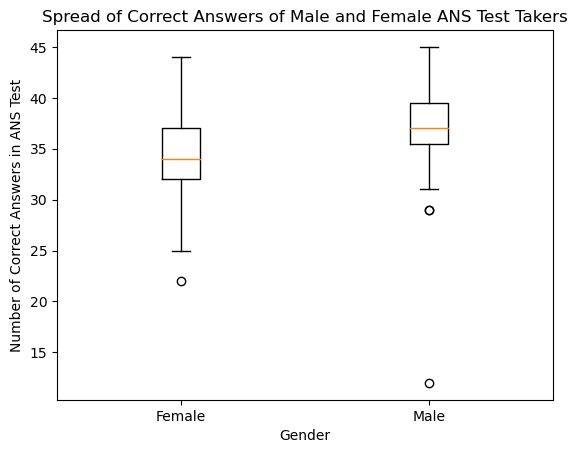

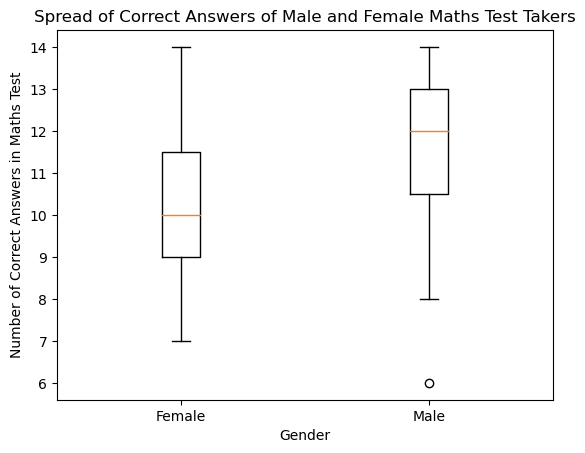

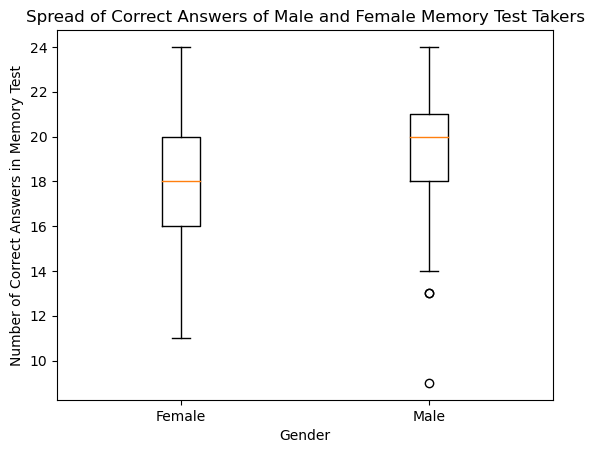

In [81]:
create_gender_boxplots()

ANS Test p value is 0.2284093853153232.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


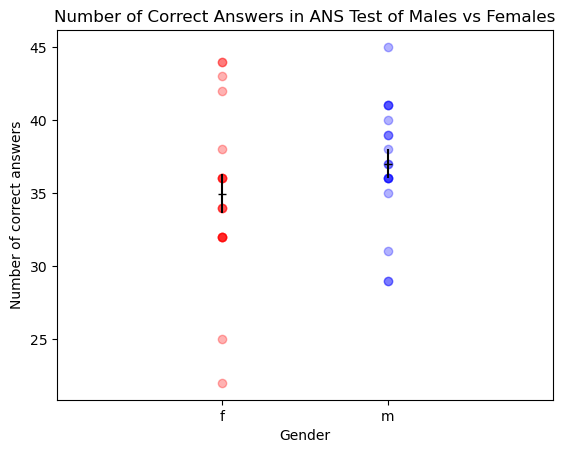

Maths Test p value is 0.3780517247723114.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


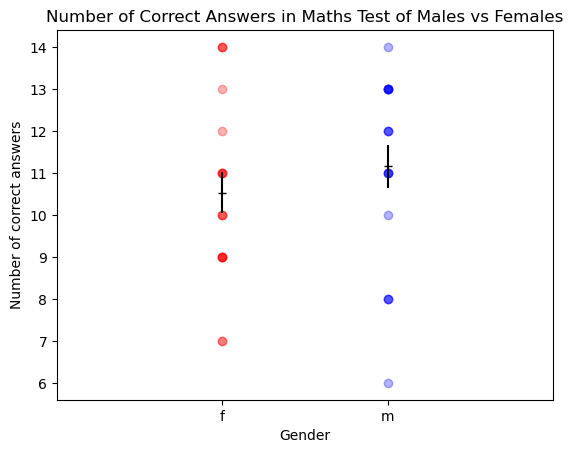

Memory Test p value is 0.42169277564887675.
The result is not significant and we fail to detect a difference in means at the 0.05 level.


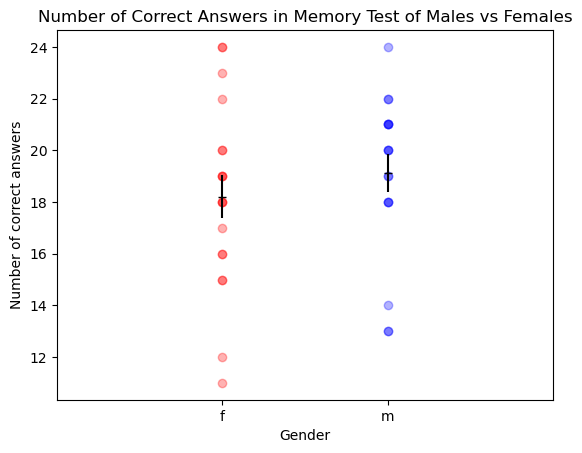

,Difference in score,Female standard error,Male standard error,Mean score female,Mean score male,P value
Test,,,,,,
ANS,-2.05,1.33,0.993,34.9,37.0,0.228
Maths,-0.632,0.492,0.509,10.5,11.2,0.378
Memory,-0.901,0.829,0.727,18.2,19.1,0.422


In [82]:
t_test_between_genders()

In [83]:
t_test_odd_even()

The mean number of odd numbered questions answered correctly is 5.8.
The mean number of even numbered questions answered correctly is 5.666666666666667.
The p value of the t test is 0.8419474572108244
The result is not significant and we fail to detect a difference in means at the 0.05 level.
